In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### to review: tidy up

key learning obj / observations: 
- how does optimisation change with: 
    - batch size, learning rate 
    - network size 
    - embedding size

- visualisation of embeddings: (through Dimension, Reduction)
    - TODO: interesting, an element of representation learning 

- side notes: 
    - nll vs cross entropy
    - pytorch internals

# Makemore
- side notes: 
    - logits: interpreting final layer output, as a log of counts (before it is transformed, into counts, then probabilities)

- part 1: bigrams training
    - estimate parameters: probability distribution for sampling: 
        - method 1:by counting (statistical/feature method): 2.47
        - method 2: by NN: gradient based learning: also around 2.46
            - with one hot encoding, it acts as index, into weights (logits output)
    - model smoothing: creates a more uniform prob distribution, to prevent zero prob assigned to any token (but without causing too much loss in information)
        - method 1: by adding 1 / a constant, to smooth the probability distribution (make it more uniform), to prevent extremes (eg. zeros)
        - method 2:
            - if W is initialised to the same value, (eg. zero, then logits w be zero, prob = 1)
            - incentivising W to be near zero, 
            - by add W**2 as regularisation term to loss function; 
            - without overpowering W learning (loss term) by adding a constant to control the 'strength' of regularisation term
        
- step 2: MLP 
    - dataset: increase context length
    - model: 
        - improved embedding 
        - cross entropy loss (same, but better than average neg log likelihood from softmax)
    - model training: (design considerations, how to improve ml training)
        - overfitting
        - batch training
        - learning rate
        - train/val/test split

    - experiments: (w design features)
        - increase hidden layers, embed size..
        - viz character embeddings O_O

    - notes: hidden layers, internal of torch.tensor!

- step 3: internals of MLP 
    - common problems/model behaviours:
        - model initialisation
        - saturated tanh
        
    - build up of nn.linear, batchnorm, tanh

- ((step 4: MLP/tensor-level backprop: (exercise!)
    - cross entropy loss, linear layer, tanh, batch norm, 1st linear layer, embedding))

- step 5: DL development - Part 3 code into pytorch, and CNN 
    - notes: torch.nn (!!), multidimension tensor shape

- step 6: GPT (transformer): 
    - attention 
    - mech int 


## NN with single layer

In [24]:
xs = torch.tensor([0, 5, 13, 13, 1])
ys = torch.tensor([5, 13, 13, 1, 0])
ys.dtype

torch.int64

In [47]:
# INITIALISE NETWORK 
# random initialisation of 27 neuron weights 
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)
W.dtype

torch.float32

In [55]:
# forward pass 

# one hot encoding (embedding, project data to dimension 27)
xenc = F.one_hot(xs, num_classes=27).float()
# SIDE_NOTE: requires same dtype
print(xenc.dtype)
print(W.dtype)

# predict log counts (data * 27 @ 27 * 27)
logits = xenc @ W
# print(logits)
# softmax: log exp ; and normalise - for prob of next token
counts = logits.exp()
probs = counts / counts.sum()

# eval: avg neg log likelihood
loss = -probs[torch.arange(5), ys].log().mean()

torch.float32
torch.float32


tensor(5.4286, grad_fn=<NegBackward0>)

In [50]:
## backward : compute gradients for all weights wrt to loss  
W.grad = None
loss.backward()

In [54]:
# update parameters based on gradients, to min loss 
# with learning rate 
W.data += -0.1 * W.grad

In [38]:
# loss : by average neg log likelihood 
# maximise likelihood of correct ground truth data 
# (by mle)

# ground trutsh
probs[0, 5], probs[1, 13], probs[2, 13], probs[3, 1], probs[4, 0]


(tensor(0.0039),
 tensor(0.0041),
 tensor(0.0042),
 tensor(0.0116),
 tensor(0.0021))

In [40]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [41]:
# get average log likelihood
# access by array 
probs[torch.arange(5), ys]

tensor([0.0039, 0.0041, 0.0042, 0.0116, 0.0021])

In [42]:
probs[torch.arange(5), ys].log().mean()

tensor(-5.4286)

In [ ]:
## compile into final training script 
## sample from 

## MLP with 2 layers

### Dataset

In [4]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [71]:
# build 'tokenizer' mapping 
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
# note end of line
stoi['.'] = 0
print(stoi.items())

itos = {i:s for s, i in stoi.items()}
print(itos)


dict_items([('a', 1), ('b', 2), ('c', 3), ('d', 4), ('e', 5), ('f', 6), ('g', 7), ('h', 8), ('i', 9), ('j', 10), ('k', 11), ('l', 12), ('m', 13), ('n', 14), ('o', 15), ('p', 16), ('q', 17), ('r', 18), ('s', 19), ('t', 20), ('u', 21), ('v', 22), ('w', 23), ('x', 24), ('y', 25), ('z', 26), ('.', 0)])
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [215]:
# build dataset
# TODO: how do we consider an appropriate context length
block_size = 3 # context length: to support prediction

X, y = [], []

for w in words:
    # print(w)
    # padded context
    context = [0] * block_size
    for ch in w + '.': 
        idx = stoi[ch]
        X.append(context)
        y.append(idx)
        # print("".join(itos[i] for i in context), '-->', itos[idx])
        context = context[1:] + [idx]
X = torch.tensor(X)
y = torch.tensor(y)

In [216]:
X.shape, X.dtype, y.shape, y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

### embedding layer

In [82]:
# embedding layer 
E = torch.randn((27, 2))
E[5] # fifth index embedding
emb = E[X] # vector indexing
emb.shape

torch.Size([32, 3, 2])

In [133]:
# model layer (hidden layer)
# TODO: rand vs randn?
# NOTE: design variable - no of neurons in W1
# inputs to layer = 3*2 (3 inputs of 2 dimensional embeddings)
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [140]:
## torch.cat
torch.cat
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape
# dim -2 / 0 - 15, 6 : across rows?
# dim -1 / 1 - 5, 6 : across columns?

torch.Size([32, 6])

In [138]:
torch.cat(torch.unbind(emb, 1), 1).shape


torch.Size([32, 6])

In [134]:
emb.view(32, 6) @ W1 # embed context length, to 2 dimensions

tensor([[ 3.0778,  1.1801, -0.4492,  ..., -3.1316, -0.4415, -1.3132],
        [ 1.8663,  0.5796, -1.4434,  ..., -2.8789, -0.8379, -0.2752],
        [-1.2311, -1.9442, -1.1858,  ..., -1.0965,  0.8735,  0.8947],
        ...,
        [-1.3761, -0.3573, -2.9813,  ...,  2.0993, -0.2359,  0.6722],
        [ 2.3641,  4.3429, -7.5268,  ..., -3.1403, -1.9140, -1.1068],
        [ 2.7147, -0.4686, -3.2007,  ...,  0.7976,  0.2672,  1.3939]])

### MLP model

key notes: familiarity with dimensions in pytorch
- embedding: 
    - -> rep learning / generalisation / dimension reduction - so that similar words will be known to be similar?
- layers: matrix multiplication
    - 6 due to context length (3) * dimension (2)
    - no of neurons: design choice - 100 
- loss function: 
    - neg log likelihood 
    - cross entropy

In [143]:
X.shape, y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [255]:
# MODEL 

# set random seed, initialisation of weights 
g = torch.Generator().manual_seed(2147483647)

# embedding 27 vocab to 2 dimensions 
E = torch.randn((27, 2), generator=g)

# weights 
# TODO; explore different hidden layers
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [E, W1, b1, W2, b2] 

for p in parameters: 
    print(p.nelement())

for p in parameters: 
    p.requires_grad = True
    
# total 
print('total:', sum(p.nelement() for p in parameters))



54
600
100
2700
27
total: 3481


### Training

#### mini batch

In [272]:
for _ in range(10): 

    # mini batch construct: 
    # get samples of 32 data points to approximate data
    # by indexing into dataset
    idx = torch.randint(0, X.shape[0], (32, ))

    # forward w cross entropy
    emb = E[X[idx]]
    h1 = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) #(32, 100)
    logits = h1 @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, y[idx])
    print(loss.item())
    # backward pass 
    # reset gradients 
    for p in parameters: 
        p.grad = None
    # call backward on loss function
    loss.backward()

    for p in parameters: 
        p.data += -0.1 * p.grad

3.9616971015930176
2.915214776992798
3.1737558841705322
3.370018482208252
3.246100902557373
3.529658317565918
4.088659763336182
3.209925651550293
3.4908461570739746
2.9342212677001953


#### learning rate

In [247]:
# to explore the space between 0.001 - 1
lre = torch.linspace(-3, 0, 50)
lrs = 10**lre
lrs.shape


torch.Size([50])

In [251]:
idx = torch.randint(0, X.shape[0], (32, ))
idx.shape

torch.Size([32])

In [252]:
lr_list = []
loss_list = []
for i in range(50): 

    # mini batch construct: 
    # get samples of 32 data points to approximate data
    # by indexing into dataset
    idx = torch.randint(0, X.shape[0], (32, ))

    # forward w cross entropy
    emb = E[X[idx]]
    h1 = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) #(32, 100)
    logits = h1 @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, y[idx])
    # print(loss.item())
    # backward pass 
    # reset gradients 
    for p in parameters: 
        p.grad = None
    # call backward on loss function
    loss.backward()
    lr = lrs[i]

    for p in parameters: 
        p.data += -lr * p.grad

    lr_list.append(lr)
    loss_list.append(loss.item())


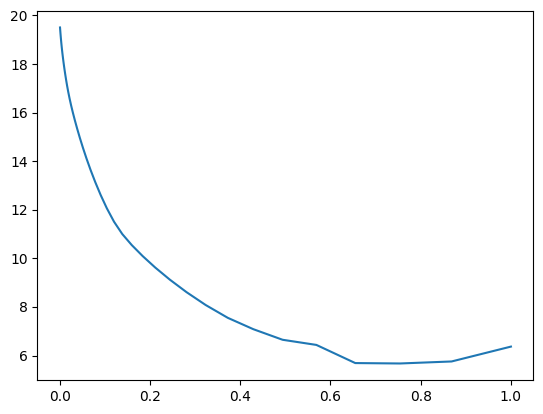

In [249]:
import matplotlib.pyplot as plt
plt.plot(lr_list, loss_list)

#### train/validation/test
- train: to train parameters
- validation: to train hyperparameters
- test: to test


- increase model size: 
    - would require longer training time 


In [ ]:
# MODEL 

# set random seed, initialisation of weights 
g = torch.Generator().manual_seed(2147483647)

# embedding 27 vocab to 2 dimensions 
E = torch.randn((27, 2), generator=g)

# weights 
# TODO; explore different hidden layers
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [E, W1, b1, W2, b2] 

for p in parameters: 
    print(p.nelement())

for p in parameters: 
    p.requires_grad = True
    
# total 
print('total:', sum(p.nelement() for p in parameters))


In [267]:
    
def build_dataset(words):
    block_size = 3 # context length: to support prediction

    X, y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.': 
            idx = stoi[ch]
            X.append(context)
            y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape, y.shape)
    return X, y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtrain, Ytrain = build_dataset(words[:n1])
print('train size', n1)
Xdev, Ydev = build_dataset(words[n1:n2])
print('val size', n2-n1)
Xtest, Ytest = build_dataset(words[n2:])
print('test size', len(words)-n2)


torch.Size([182437, 3]) torch.Size([182437])
train size 25626
torch.Size([22781, 3]) torch.Size([22781])
val size 3203
torch.Size([22928, 3]) torch.Size([22928])
test size 3204


In [261]:
# MODEL 

# set random seed, initialisation of weights 
g = torch.Generator().manual_seed(2147483647)

# embedding 27 vocab to 2 dimensions 
E = torch.randn((27, 2), generator=g)

# weights 
# TODO; explore different hidden layers
W1 = torch.randn((6, 200), generator=g)
b1 = torch.randn(200, generator=g)

W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [E, W1, b1, W2, b2] 

for p in parameters: 
    print(p.nelement())

for p in parameters: 
    p.requires_grad = True
    
# total 
print('total:', sum(p.nelement() for p in parameters))


54
1200
200
5400
27
total: 6881


In [263]:
# lr_list = []
# loss_list = []
for i in range(100): 

    # mini batch construct: 
    # get samples of 32 data points to approximate data
    # by indexing into dataset
    idx = torch.randint(0, Xtrain.shape[0], (32, ))

    # forward w cross entropy
    emb = E[Xtrain[idx]]
    h1 = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) #(32, 100)
    logits = h1 @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytrain[idx])
    # print(loss.item())
    # backward pass 
    # reset gradients 
    for p in parameters: 
        p.grad = None
    # call backward on loss function
    loss.backward()
    # lr = lrs[i]
    lr = 0.1
    for p in parameters: 
        p.data += -lr * p.grad
print(loss)
# 3.5327

    # lr_list.append(lr)
    # loss_list.append(loss.item())


tensor(3.1096, grad_fn=<NllLossBackward0>)


In [265]:
emb = E[Xtrain]
h1 = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) #(32, 100)
logits = h1 @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytrain)
loss

tensor(3.5194, grad_fn=<NllLossBackward0>)

In [268]:
emb = E[Xdev]
h1 = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) #(32, 100)
logits = h1 @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(3.5305, grad_fn=<NllLossBackward0>)

## Viz Embedding vectors
- mine is quite different from his video..?
- increase embedding size : 
    - (TBC) observe improvements of loss 

In [270]:
C = E

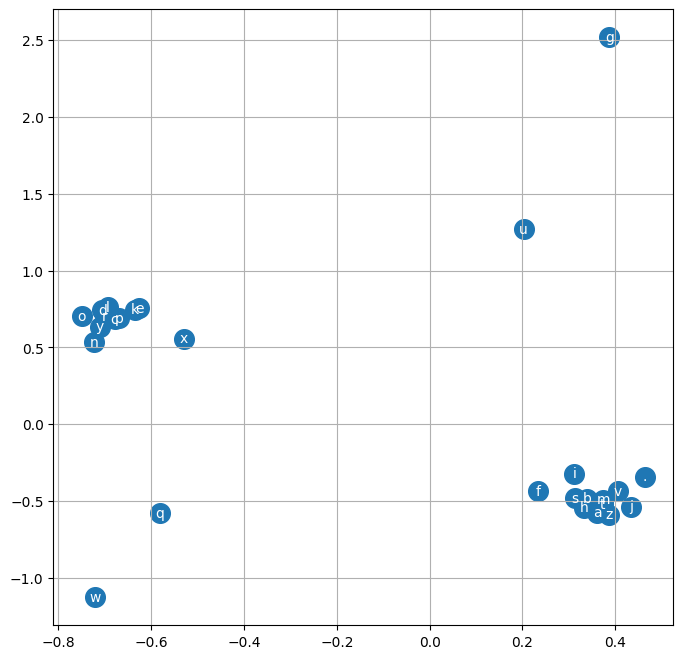

In [271]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Sample from Model 

In [282]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True: 
        emb = E[context]
        # print(emb) # (batch size, context length, embed dimension size)
        # print(emb.shape) # note torch.view
        h1 = torch.tanh(emb.view(1, -1) @ W1 + b1) #(32, 100)
        logits = h1 @ W2 + b2 # (32, 27)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

denzelinaleurtsoenn.
yhnmvonimjdnaierlsndn.
knn.
g.
dnniyauknatsrugotssmmdriellnio.
nennednaknneakensede.
eniaonnny.
gene.
mhgeaeenntallvou.
dnd.
dennenlnnynn.
ivvnn.
veidnnnnezkm.
denn.
mdent.
geaelnshzdbssmrh.
ducl.
zen.
nrnnln.
meh.


In [278]:
W1.shape

torch.Size([6, 200])

## Next steps: how to improve the loss
- embedding size 
- size of neural net 
- context length
- optimisation considerations: (?)
    - how long you're training for, learning rate, 
    - what is the decay rate 
    - batch size,  

### (TBC, to tidy up) nll vs cross entropy

In [197]:
# forward 
emb = E[X]
h1 = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) #(32, 100)
logits = h1 @ W2 + b2 # (32, 27)

# classification (amongst)
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
# neg log likelihood of the ground truths 
# TODO: why log again?
# to max mle wrt to ground truths
# TODO: need to compute entire dataset..? :")"
loss = -prob[torch.arange(32), y].log().mean()
loss

tensor(17.7697)

In [186]:
# forward w cross entropy
emb = E[X]
h1 = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) #(32, 100)
logits = h1 @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, y)

# backward pass 
# reset gradients 
for p in parameters: 
    p.grad = None
# call backward on loss function
loss.backward()

for p in parameters: 
    p.data += -0.1 * p.grad


tensor(17.7697)

In [206]:
for p in parameters: 
    p.requires_grad = True

In [228]:
for _ in range(1000): 
    # forward w cross entropy
    emb = E[X]
    h1 = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) #(32, 100)
    logits = h1 @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, y)
    print(loss.item())
    # backward pass 
    # reset gradients 
    for p in parameters: 
        p.grad = None
    # call backward on loss function
    loss.backward()

    for p in parameters: 
        p.data += -0.1 * p.grad

print(loss.item())

5.292376518249512
5.228204250335693
5.165928840637207
5.105469226837158
5.046748161315918
4.989699363708496
4.934262275695801
4.880381107330322
4.828006744384766
4.777096271514893
4.727610111236572
4.6795148849487305
4.632780075073242
4.5873799324035645
4.543290138244629


KeyboardInterrupt: 

In [211]:
logits.max(1)

torch.return_types.max(
values=tensor([11.8757, 14.7360, 19.4288, 18.6884, 14.4438, 11.8757, 13.9851, 12.5299,
        14.2254, 16.2040, 13.6982, 18.7317, 11.8757, 14.4621, 15.1171, 17.8948,
        11.8757, 14.6504, 12.6960, 14.5733, 16.6689, 13.5914,  8.8711,  8.8290,
        14.3545, 11.8757, 14.3465, 14.8591, 11.5852, 14.8667, 16.7810, 13.3449],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0]))

### how to decide learning rate 
- run optimisation step over a range of learning rate, starting from small to big.. 
- plot (loss against learning rate) and observe where the dip is

### side note: pytroch internals 
- torch.view() - efficient
- torch.storage()

In [129]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [130]:
a.view(2, 9) #object separate from storage, that stores 'mulitdimensional' intepretation of the array 
# strides, ... etc

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [131]:
a.storage() #does not change, no matter our dimension representation

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

### side note: nll loss function vs pytorch.cross_entropy
- pytorch cross entropy: 
    - more efficient implementation (fused kernels..?)
    - more efficient back prop
    - more numerically well behaved: 
        - problem: positive extreme numbers have tendency to overflow, whilst negaitve numbers are ok (why?)
        - pytroch solution: because there is normalisation, a constant offset does not affect the result 
        - hence pytorch subtracts max positive number as offset, for numerical stability

In [ ]:
# gather parameters 

In [ ]:
# update and optimise 